In [1]:
# Cell 1: Imports and Setup
import networkx as nx
import matplotlib.pyplot as plt
from topolansatz.topology import TopologyHandler
from topolansatz.circuits import CircuitBuilder
from topolansatz.evaluator import CircuitEvaluator
from topolansatz.stitching import CircuitStitcher
from topolansatz.main import TopolAnsatz
import time

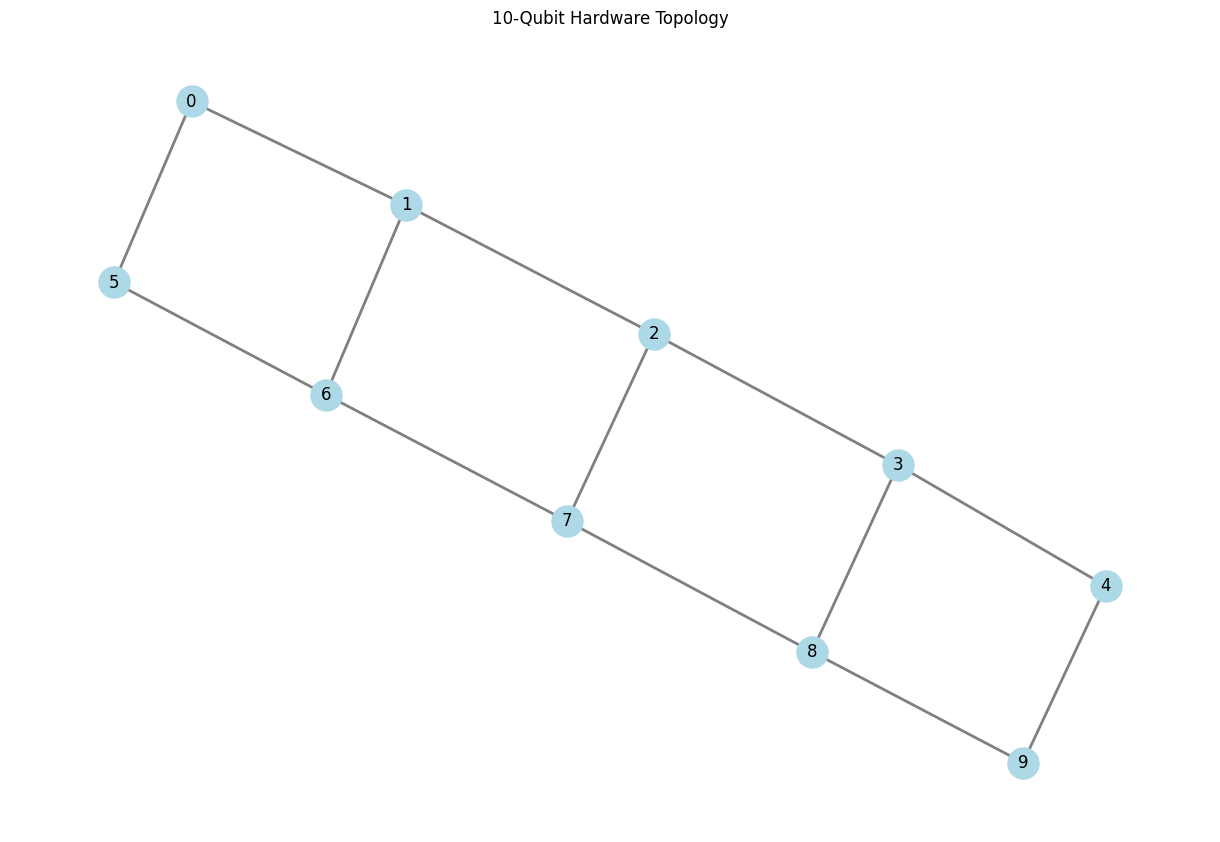

Topology Analysis:
----------------------------------------
Number of qubits: 10
Number of connections: 13
Average degree: 2.60


In [2]:
# Cell 2: Define Target Hardware Topology
def create_ibm_topology():
    """Create IBM Mumbai topology subset suitable for 10 qubits"""
    coupling_map = [
        (0,1), (1,2), (2,3), (3,4), # Row 0
        (0,5), (1,6), (2,7), (3,8), (4,9), # Vertical connections
        (5,6), (6,7), (7,8), (8,9)  # Row 1
    ]
    return coupling_map

# Create and visualize topology
coupling_map = create_ibm_topology()
G = nx.Graph(coupling_map)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, width=2, edge_color='gray')
plt.title("10-Qubit Hardware Topology")
plt.show()

print("Topology Analysis:")
print("-" * 40)
print(f"Number of qubits: {G.number_of_nodes()}")
print(f"Number of connections: {G.number_of_edges()}")
print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

Finding Suitable Subgraph Partitions
----------------------------------------

Trying partition (5, 5):
✓ Found 5-qubit subgraph: [0, 1, 2, 3, 4]
✓ Found 5-qubit subgraph: [5, 6, 7, 8, 9]
✓ Valid partition found!


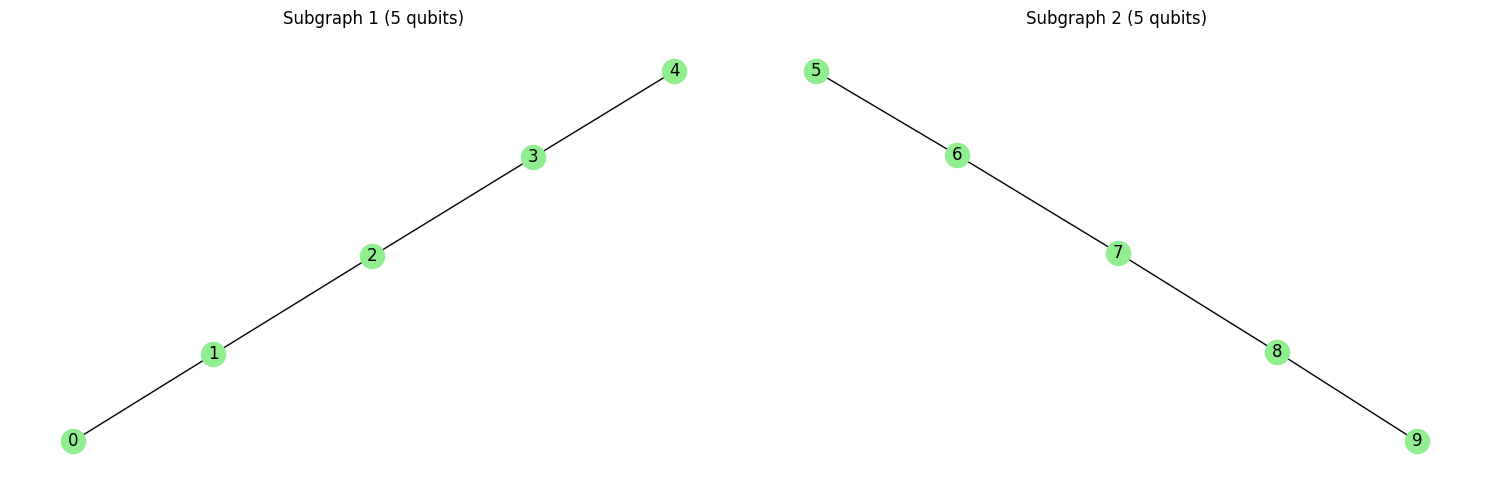

In [3]:
# Cell 3: Find Suitable Subgraphs
topology = TopologyHandler(coupling_map)

# Find potential subgraph divisions
print("Finding Suitable Subgraph Partitions")
print("-" * 40)

# Try different subgraph sizes
partitions = [
    (5, 5),  # Two 5-qubit subgraphs
    (6, 4),  # 6 and 4 qubit subgraphs
    (4, 4, 2)  # Three subgraphs
]

for sizes in partitions:
    print(f"\nTrying partition {sizes}:")
    total_qubits = sum(sizes)
    
    if total_qubits != 10:
        print(f"✗ Partition sum ({total_qubits}) != target size (10)")
        continue
        
    subgraphs = []
    used_qubits = set()
    
    # Try to find subgraphs of each size
    success = True
    for size in sizes:
        possible_subgraphs = topology.get_connected_subgraphs(size)
        
        # Filter subgraphs to avoid used qubits
        valid_subgraphs = []
        for sg in possible_subgraphs:
            sg_qubits = set(sg.nodes())
            if not sg_qubits.intersection(used_qubits):
                valid_subgraphs.append(sg)
        
        if not valid_subgraphs:
            print(f"✗ Could not find valid {size}-qubit subgraph")
            success = False
            break
            
        # Take first valid subgraph
        chosen_sg = valid_subgraphs[0]
        subgraphs.append(chosen_sg)
        used_qubits.update(chosen_sg.nodes())
        print(f"✓ Found {size}-qubit subgraph: {list(chosen_sg.nodes())}")
    
    if success:
        print("✓ Valid partition found!")
        chosen_partition = sizes
        chosen_subgraphs = subgraphs
        break

if not success:
    raise ValueError("Could not find valid subgraph partition")

# Visualize chosen subgraphs
plt.figure(figsize=(15, 5))
for i, sg in enumerate(chosen_subgraphs):
    plt.subplot(1, len(chosen_subgraphs), i+1)
    nx.draw(sg, with_labels=True, node_color='lightgreen')
    plt.title(f"Subgraph {i+1} ({len(sg.nodes())} qubits)")
plt.tight_layout()
plt.show()

In [4]:
# Cell 4: Generate SubCircuits
print("Generating SubCircuits")
print("-" * 40)

subcircuits = []
subgraph_mappings = []
depth = 2  # Circuit depth per subcircuit

for i, subgraph in enumerate(chosen_subgraphs):
    print(f"\nGenerating circuit for subgraph {i+1}:")
    # Normalize subgraph indices
    norm_graph, mapping = topology.normalize_indices(subgraph)
    print(f"Qubit mapping: {mapping}")
    
    # Create circuit builder
    builder = CircuitBuilder(norm_graph, f"sub_{i}")
    circuit = builder.create_circuit(depth)
    
    print(f"Circuit statistics:")
    print(f"- Number of qubits: {circuit.num_qubits}")
    print(f"- Circuit depth: {circuit.depth()}")
    print(f"- Parameters: {len(circuit.parameters)}")
    
    # Count gates
    gate_counts = {}
    for inst in circuit.data:
        gate_name = inst.operation.name
        gate_counts[gate_name] = gate_counts.get(gate_name, 0) + 1
    print(f"- Gate counts: {gate_counts}")
    
    subcircuits.append(circuit)
    subgraph_mappings.append(mapping)

Generating SubCircuits
----------------------------------------

Generating circuit for subgraph 1:
Qubit mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Circuit statistics:
- Number of qubits: 5
- Circuit depth: 8
- Parameters: 6
- Gate counts: {'ry': 1, 'rz': 2, 'rx': 3, 'cx': 8, 'h': 2, 'x': 2}

Generating circuit for subgraph 2:
Qubit mapping: {0: 5, 1: 6, 2: 7, 3: 8, 4: 9}
Circuit statistics:
- Number of qubits: 5
- Circuit depth: 8
- Parameters: 6
- Gate counts: {'rx': 3, 's': 2, 'x': 1, 'cx': 4, 'swap': 4, 'rz': 3, 't': 1}


Finding Stitching Points
----------------------------------------
Found 5 possible connection points:
Connection 1: Qubit 0 - Qubit 5
Connection 2: Qubit 1 - Qubit 6
Connection 3: Qubit 2 - Qubit 7
Connection 4: Qubit 3 - Qubit 8
Connection 5: Qubit 4 - Qubit 9


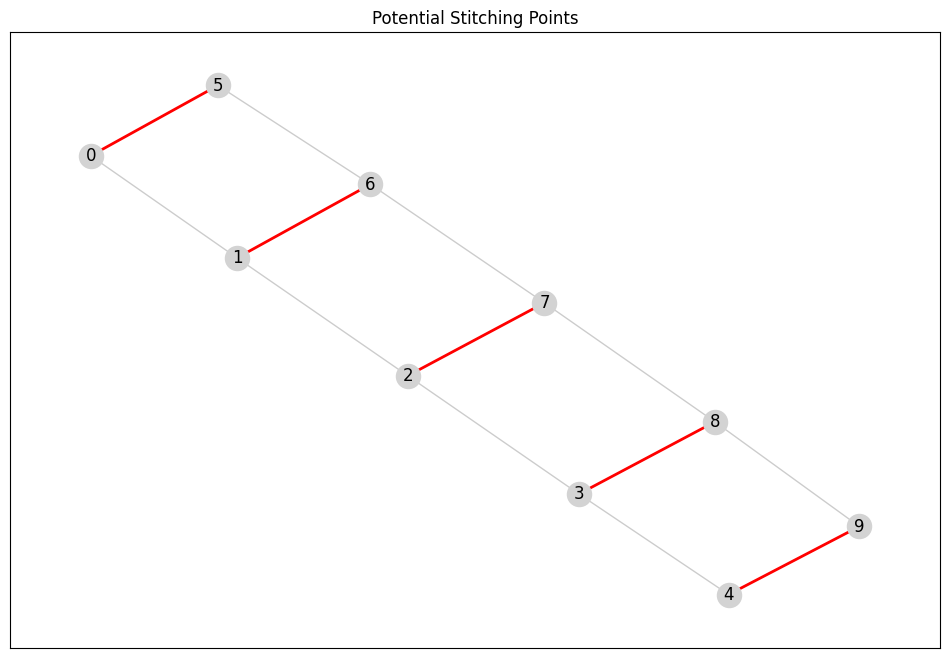

In [5]:
# Cell 5: Find Stitching Points
stitcher = CircuitStitcher(CircuitEvaluator(), G)
print("Finding Stitching Points")
print("-" * 40)

connections = stitcher.find_connection_points(subgraph_mappings)
print(f"Found {len(connections)} possible connection points:")
for i, (q1, q2) in enumerate(connections):
    print(f"Connection {i+1}: Qubit {q1} - Qubit {q2}")

# Visualize connection points
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
# Draw base topology
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, node_color='lightgray')
nx.draw_networkx_labels(G, pos)

# Draw connection points in red
conn_graph = nx.Graph()
conn_graph.add_edges_from(connections)
nx.draw_networkx_edges(conn_graph, pos, edge_color='red', width=2)
plt.title("Potential Stitching Points")
plt.show()

In [6]:
# Cell 6: Generate Final Ansatz
print("Generating Final Ansatz")
print("-" * 40)

# Initialize TopolAnsatz
topol = TopolAnsatz(coupling_map)

# Generate ansatz with specific subgraph partitioning
start_time = time.time()
ansatz = topol.generate_partitioned_ansatz(partition_sizes=chosen_partition)
gen_time = time.time() - start_time

print(f"Generation time: {gen_time:.2f} seconds")
print(f"\nAnsatz properties:")
print(f"- Number of qubits: {ansatz.num_qubits}")
print(f"- Circuit depth: {ansatz.depth()}")
print(f"- Number of parameters: {len(ansatz.parameters)}")

# Count gates in final ansatz
gate_counts = {}
for inst in ansatz.data:
    gate_name = inst.operation.name
    gate_counts[gate_name] = gate_counts.get(gate_name, 0) + 1

print("\nGate composition:")
for gate, count in gate_counts.items():
    print(f"- {gate}: {count}")

# Evaluate circuit quality
metrics = topol.evaluate_ansatz(ansatz)
print("\nCircuit quality metrics:")
for metric, value in metrics.items():
    print(f"- {metric}: {value:.4f}")

# Draw final circuit
print("\nFinal Circuit Diagram:")
print(ansatz.draw())

Generating Final Ansatz
----------------------------------------
Generation time: 0.01 seconds

Ansatz properties:
- Number of qubits: 10
- Circuit depth: 2
- Number of parameters: 5

Gate composition:
- circuit-164: 1
- circuit-165: 1
- cx: 2

Circuit quality metrics:
- expressivity: 1.1484
- entanglement: 0.7144
- depth: 2.0000
- n_parameters: 5.0000
- n_cnot: 2.0000

Final Circuit Diagram:
     ┌──────────────────────────────────────────────────────┐          
q_0: ┤0                                                     ├──■───────
     │                                                      │  │       
q_1: ┤1                                                     ├──┼────■──
     │                                                      │  │    │  
q_2: ┤2 circuit-164(θ_sub_0_ry_0,θ_sub_0_rz_1,θ_sub_0_rz_2) ├──┼────┼──
     │                                                      │  │    │  
q_3: ┤3                                                     ├──┼────┼──
     │                      